# Light transport simulation 

## Emission

The following algorithm computes the photon flux in the volume surrounding a light emitter. The result is a 3D array containing the probability of any emitted photon passing through that point per unit area (mm$^2$). 


Denote this probability as $q(\mathbf z)$. Note that this is not a probability density function. Rather, the integral $$\ell = \iiint_{\mathbf z \in \Omega} q(\mathbf z) d \mathbf z$$ evaluates the average travel length of an emitted photon in the integrated region $\Omega$.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
import tqdm

In [2]:
class Space:
    
    def __init__(self, pitch=1, dims=(400, 400, 400), emission_spread="lambertian", 
                 anisotropy=0.88, absorption_length=14000, scatter_length=100, 
                 beam_compression=1.0, beam_xy_aspect=1.0, y_steer=0.0, emitter_size=(10,10)):
        # irradiation field grid
        self.pitch = pitch   # (um) voxel pitch 
        self.dims = dims     # voxels
        self.emitter_size = np.array(list(emitter_size) + [0])  # (um) (width, height, depth) (x, y, z)
        
        # simulated photon packets: positions and directions
        self.n = 8192  # photon packets at a time
        self.positions = np.empty((self.n, 3))   # (um)   x, y, z
        self.directions = np.empty((self.n, 3))  # (um)   x, y, z 
        
        # simulation parameters
        self.emission_spread = emission_spread
        self.mui = 1/absorption_length   # absorption rate: 1/um
        self.mue = 1/scatter_length   # scatter rate: 1/um
        self.mu = self.mui + self.mue  # total rate
        self.absorb_ratio = self.mui/self.mu  # probability of absoprtion at each hop
        self.anisotropy = anisotropy  # For the Henyey-Greenstein formula
        self.beam_compression = beam_compression
        self.beam_xy_aspect = beam_xy_aspect
        self.y_steer = y_steer  # (radians) steer angle        

        self.volume = np.zeros(self.dims) # x, y, z
        self.total_count = 0
        
    def emit(self, which):
        """
        generate new photons
        :param which: 
        """
        # generate positions
        m = which.sum()
        self.positions[which, :] = (np.random.rand(m, 3)-0.5) * self.emitter_size # intial position
        
        # generate directions
        if self.emission_spread == "parallel":
            self.directions[which, :] = 0, 0, 1  # beam along z axis
        elif self.emission_spread == "spherical":
            # sphere of radius 5 um
            radius = 5
            positions = np.random.randn(m, 3)
            positions *= radius/np.sqrt((positions ** 2).sum(axis=1, keepdims=True))
            self.positions[which, :] = positions
            directions = np.random.randn(m, 3) 
            directions /= np.sqrt((directions ** 2).sum(axis=1, keepdims=True))
            self.directions[which, :] = directions
        elif self.emission_spread == "lambertian":
            elev_sin = np.random.rand(m)**0.5   # sine of elevation
            azimuth = np.random.rand(m) * 2 * np.pi   
            azi_cos, azi_sin = np.cos(azimuth), np.sin(azimuth)
            
            # beam compression 
            if self.beam_compression != 1:
                elev_sin = np.sin(np.arcsin(elev_sin) * self.beam_compression)  # always positive
            if self.beam_xy_aspect != 1:
                azi_sin = np.arcsin(azi_sin) / self.beam_xy_aspect
                azi_cos = np.sign(azi_cos) * np.sqrt(1 - azi_sin*azi_sin)
            vx, vy, vz = elev_sin*azi_cos, elev_sin*azi_sin, np.sqrt(1-elev_sin*elev_sin)
            
            # beam steering around the x-axis
            if self.y_steer:
                steer_cos, steer_sin = np.cos(self.y_steer), np.sin(self.y_steer)
                vz, vy = steer_cos * vz - steer_sin * vy, steer_sin * vz + steer_cos * vy              
            self.directions[which, :] = np.stack((vx, vy, vz)).T 
        else:
            raise Exception('invalid emission type')
        
    def accumulate(self, start_points, end_points, lengths):
        """
        accumulate irradiation intensity between start_points and end_points
        """
        samples = 8   # points per hop  
        for i in range(samples):
            fractions = np.random.rand(self.n)[:, None]
            dims = np.array(self.dims)
            positions = np.round(dims/2 + 
                (start_points * fractions + end_points * (1 - fractions)) / self.pitch).astype(np.int32)
            keep = np.all(np.logical_and(positions >= 0, positions < dims), axis=1)
            positions = positions[keep, :]
            indices = np.ravel_multi_index((positions[:,0], positions[:,1], positions[:,2]), self.volume.shape)
            self.volume.ravel()[indices] += lengths[keep] / self.pitch / samples
        
    def hop(self):
        """
        execute photon hops between events, updating the irradition field
        """
        # irradiate
        lengths = np.random.exponential(1./self.mu, self.n) 
        new_positions = self.positions + lengths[:, None] * self.directions
        self.accumulate(self.positions, new_positions, lengths)
        self.positions = new_positions
        
        # absorb
        absorbed = np.random.rand(self.n) < self.absorb_ratio
        self.emit(absorbed)  # eliminate and absorb new ones
        self.total_count += absorbed.sum()
        
        # scatter: gcos follows the Henyey-Greenstein distribution of cosines
        scattered = np.logical_not(absorbed)
        m = scattered.sum()
        g = self.anisotropy
        gcos = 0.5 / g * (1 + g*g - ((1 - g*g)/(1 - g + 2*g * np.random.rand(m)))**2)
        gsin = np.sqrt(1-gcos*gcos)
        v = self.directions[scattered] * np.sign(gcos[:, None])
        d = np.random.randn(m, 3)*0.001
        d -= v * (v*d).sum(axis=1, keepdims=True)  # random orthogonal vector
        v += gsin[:,None] / np.sqrt((d**2).sum(axis=1, keepdims=True)) * d  # match length to gsin
        v /= np.sqrt((v**2).sum(axis=1, keepdims=True))  # normalize
        self.directions[scattered, :] = v        
        
    def run(self, hops=500):
        self.emit(np.ones(self.n, dtype=np.bool))
        for _ in tqdm.tqdm(range(hops)):
            self.hop()
        # at the end, the values in volumes depict the photon flux per um^2 per emitted photons
        self.volume /= self.total_count
            
            
    def plot(self, axis=None, title="", gamma=0.5):
        if axis is None:
            _, axis = plt.subplots(1, 1, figsize=(8, 8))
        axis.imshow((self.volume.sum(axis=0))**gamma, cmap='magma')
        axis.axis(False)
        scale_bar = ScaleBar(self.pitch*1e-6)
        axis.add_artist(scale_bar)
        title = f"{title}: {space.total_count/1e6:0.2f} million simulated photons"
        axis.set_title(title)

# Tests

100%|██████████| 2000/2000 [00:12<00:00, 162.40it/s]


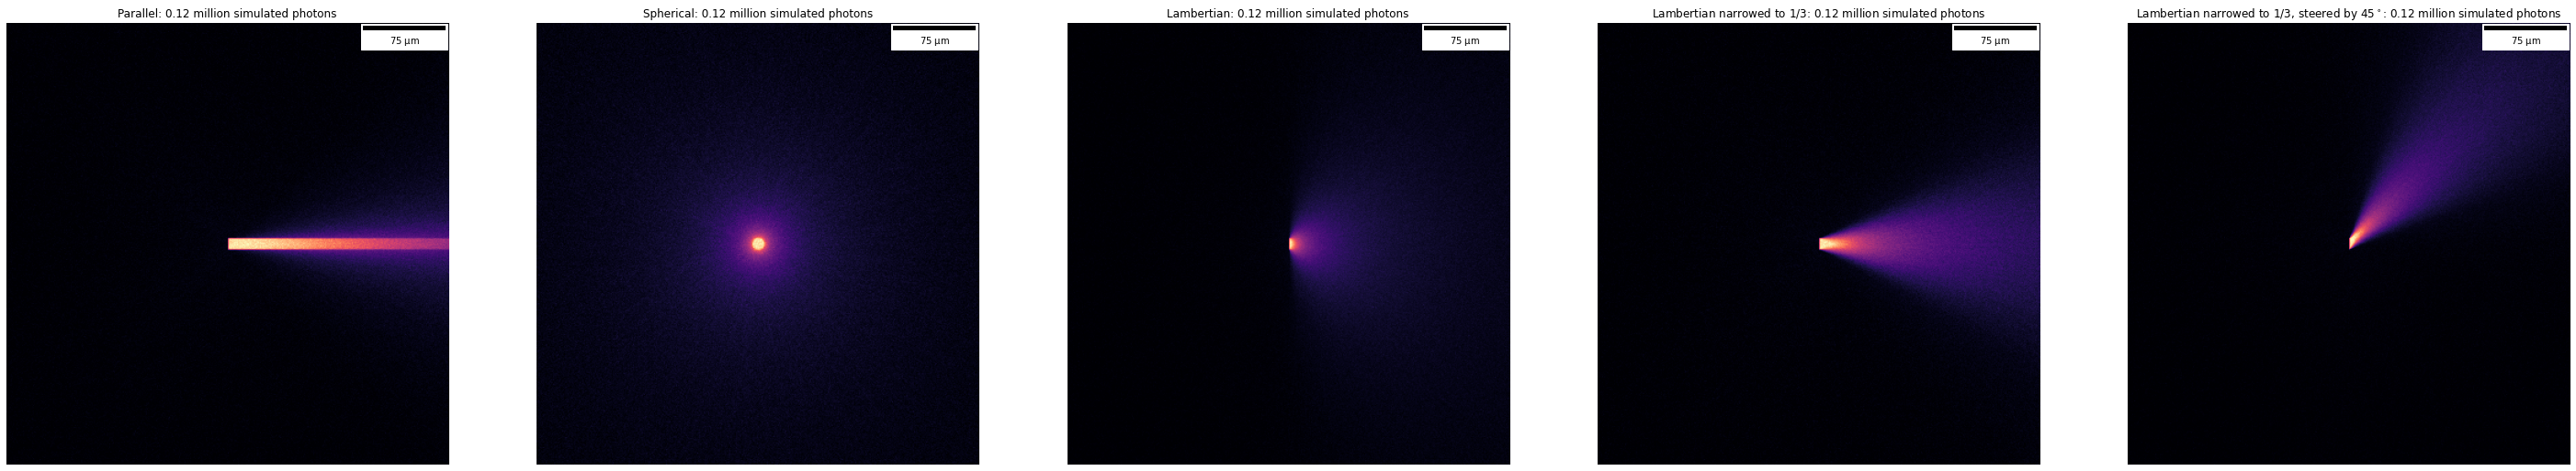

In [3]:
fig, ax = plt.subplots(1, 5, figsize=(50, 10))

display_gamma = 0.7
iterations = 2000

space = Space(emission_spread="parallel")
space.run(iterations)
space.plot(ax[0], "Parallel", gamma=display_gamma)


space = Space(emission_spread="spherical", emitter_size=(0,0))
space.run(iterations)
space.plot(ax[1], "Spherical", gamma=display_gamma)

space = Space()
space.run(iterations)
space.plot(ax[2], "Lambertian", gamma=display_gamma)

space = Space(beam_compression=1/3)
space.run(iterations)
space.plot(ax[3], "Lambertian narrowed to $1/3$", gamma=display_gamma)

space = Space(beam_compression=1/3, y_steer=-np.pi/4)
space.run(iterations)
space.plot(ax[4], "Lambertian narrowed to $1/3$, steered by $45^\circ$", gamma=display_gamma)



In [4]:
space.volume.sum()

308.4087446442689

## Detection

The detection calculation works similarly to emission. A single spherically symmetric emitter is placed at the orign. When light is propaged through space at point $\mathbf z$, it is equivalent to a photon arriving at a detector placed at the origin from an emitter placed at $-\mathbf z$. Assuming that the detector is facing along the unit vector $\mathbf u = (0, 0, 1)$, the accumulation at point $\mathbf z$ is updated with the sensitivity function based on the angle from $\mathbf u$.  

In [5]:
class Space:
    
    def __init__(self, pitch=1, dims=(400, 400, 400), emission_spread="lambertian", 
                 anisotropy=0.88, absorption_length=14000, scatter_length=100, 
                 beam_compression=1.0, beam_xy_aspect=1.0, y_steer=0.0, emitter_size=(10,10)):
        # irradiation field grid
        self.pitch = pitch   # (um) voxel pitch 
        self.dims = dims     # voxels
        self.emitter_size = np.array(list(emitter_size) + [0])  # (um) (width, height, depth) (x, y, z)
        
        # simulated photon packets: positions and directions
        self.n = 8192  # photon packets at a time
        self.positions = np.empty((self.n, 3))   # (um)   x, y, z
        self.directions = np.empty((self.n, 3))  # (um)   x, y, z 
        
        # simulation parameters
        self.emission_spread = emission_spread
        self.mui = 1/absorption_length   # absorption rate: 1/um
        self.mue = 1/scatter_length   # scatter rate: 1/um
        self.mu = self.mui + self.mue  # total rate
        self.absorb_ratio = self.mui/self.mu  # probability of absoprtion at each hop
        self.anisotropy = anisotropy  # For the Henyey-Greenstein formula
        self.beam_compression = beam_compression
        self.beam_xy_aspect = beam_xy_aspect
        self.y_steer = y_steer  # (radians) steer angle        

        self.volume = np.zeros(self.dims) # x, y, z
        self.total_count = 0
        
    def emit(self, which):
        """
        generate new photons
        :param which: 
        """
        # generate new photons positions
        m = which.sum()
        self.detector_offsets = (np.random.rand(m, 3)-0.5) * self.emitter_size # intial position
        self.positions[which, :] = self.detector_offsets
        
    def accumulate(self, start_points, end_points, lengths):
        """
        accumulate irradiation intensity between start_points and end_points
        """
        samples = 8   # points per hop  
        for i in range(samples):
            fractions = np.random.rand(self.n)[:, None]
            dims = np.array(self.dims)
            positions = np.round(dims/2 + 
                (start_points * fractions + end_points * (1 - fractions)) / self.pitch).astype(np.int32)
            keep = np.all(np.logical_and(positions >= 0, positions < dims), axis=1)
            positions = positions[keep, :]
            indices = np.ravel_multi_index((positions[:,0], positions[:,1], positions[:,2]), self.volume.shape)
            self.volume.ravel()[indices] += (self.detector_sensitivity() * lengths)[keep] / self.pitch / samples
            
            
    def detector_sensitivity(self):
        """
        Detection selectivity based on 
        incident angles self.directions and 
        detector offsets self.detector_offsets
        """
        # return np.maximum(0, np.sign(self.directions[:,2]))  # lambertian 
        return np.maximum(0, self.directions[:,2])**4
        
        
        
    def hop(self):
        """
        execute photon hops between events, updating the irradition field
        """
        # irradiate
        lengths = np.random.exponential(1./self.mu, self.n) 
        new_positions = self.positions + lengths[:, None] * self.directions
        self.accumulate(self.positions, new_positions, lengths)
        self.positions = new_positions
        
        # absorb
        absorbed = np.random.rand(self.n) < self.absorb_ratio
        self.emit(absorbed)  # eliminate and absorb new ones
        self.total_count += absorbed.sum()
        
        # scatter: gcos follows the Henyey-Greenstein distribution of cosines
        scattered = np.logical_not(absorbed)
        m = scattered.sum()
        g = self.anisotropy
        gcos = 0.5 / g * (1 + g*g - ((1 - g*g)/(1 - g + 2*g * np.random.rand(m)))**2)
        gsin = np.sqrt(1-gcos*gcos)
        v = self.directions[scattered] * np.sign(gcos[:, None])
        d = np.random.randn(m, 3)*0.001
        d -= v * (v*d).sum(axis=1, keepdims=True)  # random orthogonal vector
        v += gsin[:,None] / np.sqrt((d**2).sum(axis=1, keepdims=True)) * d  # match length to gsin
        v /= np.sqrt((v**2).sum(axis=1, keepdims=True))  # normalize
        self.directions[scattered, :] = v      
        
    def run(self, hops=500):
        self.emit(np.ones(self.n, dtype=np.bool))
        for _ in tqdm.tqdm(range(hops)):
            self.hop()
        # at the end, the values in volumes depict the photon flux per um^2 per emitted photons
        self.volume /= self.total_count
            
    def plot(self, axis=None, title="", gamma=0.5):
        if axis is None:
            _, axis = plt.subplots(1, 1, figsize=(8, 8))
        axis.imshow((self.volume.sum(axis=0))**gamma, cmap='gray_r')
        axis.axis(False)
        scale_bar = ScaleBar(self.pitch*1e-6)
        axis.add_artist(scale_bar)
        title = f"{title}: {space.total_count/1e6:0.2f} million simulated photons"
        axis.set_title(title)

  0%|          | 0/2000 [00:00<?, ?it/s]/Users/dimitri/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in power
/Users/dimitri/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:90: RuntimeWarning: overflow encountered in multiply
/Users/dimitri/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:91: RuntimeWarning: overflow encountered in square
/Users/dimitri/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in multiply
100%|██████████| 2000/2000 [00:12<00:00, 161.13it/s]


Text(0.5, 0.98, 'Detection fields')

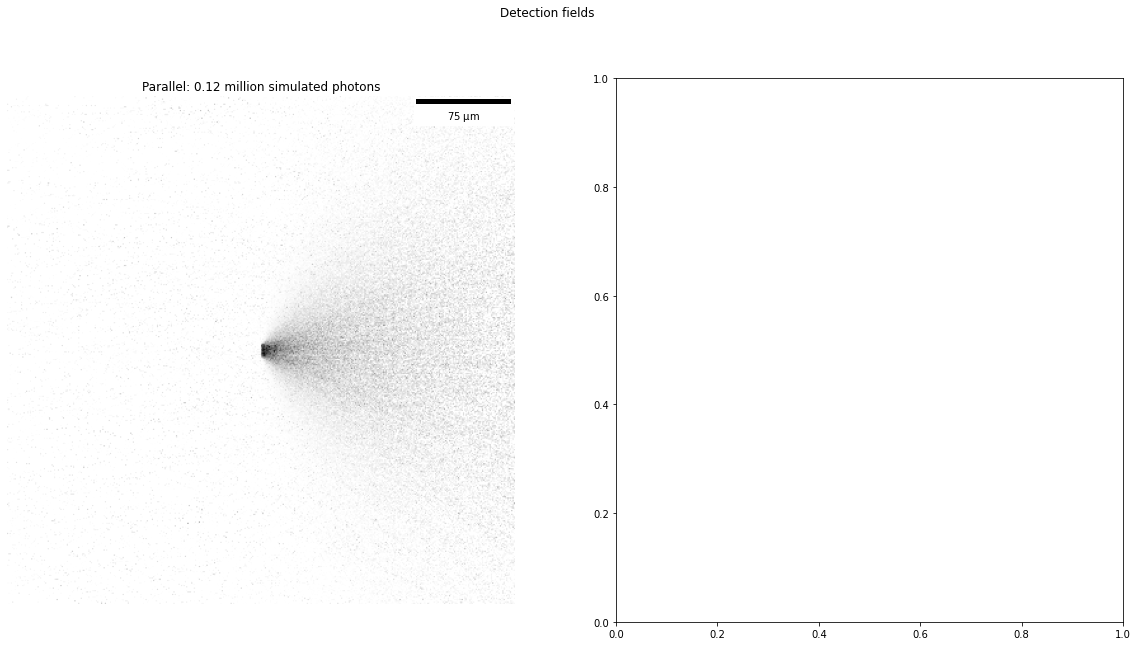

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

display_gamma = 0.7
iterations = 2000

space = Space(emission_spread="Unselective (lambertian)")
space.run(iterations)
space.plot(ax[0], "Parallel", gamma=display_gamma)

fig.suptitle('Detection fields')